In [1]:
# packages and initial data import

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import operator
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score, cross_val_predict
from sklearn.feature_selection import chi2, SelectKBest, SelectFromModel
import category_encoders as ce
from sklearn import metrics, linear_model, preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score,\
                            roc_auc_score, precision_score, recall_score
from sklearn.preprocessing import normalize, power_transform, PowerTransformer
from datetime import datetime, timedelta
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
import warnings

pd.set_option('display.max_columns', None) # display all columns
warnings.simplefilter('ignore')   #suppress warning messages 

training = pd.read_csv('Train_Churn_binary.csv', header = 0)
testing = pd.read_csv('Test_Churn.csv', header = 0)

In [2]:
testing.shape

(1761, 21)

In [26]:
def do_data(df, has_y = True, return_df = False):
    """
    Takes as input a dataframe of customer churn data and returns dataframe X and series y.
    Useful for repeatedly & consistently transforming & prepping data for modeling.
    All columns of dtype 'object' will be converted to categorical.
    
    Parameters
    ----------
    df : dataframe
    has_y (optional) : flag to indicate if df contains labeled churn outcome. default = True
    return_df (optional) : flag to have function return non-split dataframe. 
    
    Returns
    -------
    X : dataframe of features / independent variables
    y : series of labeled outcomes / dependent variables
    df : cleaned/transformed dataframe
    """

    df.columns = map(str.lower, df.columns) # all column headers to lower case
    y = df['churn']
    df = df.drop(columns=['churn','customer number'])
    """____________________________________________________________________________________________"""
    
    """________________for the many experimenting of the feature engineerings______________________"""

    if df['totalcharges'].dtype == 'object': 
        df['totalcharges'] = df['totalcharges'].replace({" ": 0}) #replace 'space' missing values with 0 (super sneaky)
        df['totalcharges'] = df['totalcharges'].astype(float)
    
    PT = PowerTransformer()                                   
    charge_array = df['totalcharges'].to_numpy().reshape(-1,1)  
    df['totalcharges'] = PT.fit_transform(charge_array)       
    
    def bandwidth_use(row):
        "a naive function to estimate the bandwidth use of a customer given the products they subscribe to."
        
        if row['internetservice'] != 'No':
            if row['streamingtv'] and row['streamingmovies']  == 'Yes':
                return 'high'
            elif row['streamingtv'] and row['streamingmovies'] and row['onlinebackup'] == 'No':
                return 'low'
            elif row['streamingtv'] or row['streamingmovies'] or row['onlinebackup'] == 'Yes':
                return 'medium'
        else:
            return 'none'

    df['bandwidth_use'] =  df.apply(bandwidth_use, axis = 1)
    
    def mismatch(row):
        """a naive function to estimate if a customer has too much or too little internet service given
            their internet service type and estimated bandwidth use"""
        
        if row['internetservice'] == 'Fiber optic' and (row['bandwidth_use'] == 'low' or row['bandwidth_use'] == 'none'):
            return 'yes'
        elif row['internetservice'] == 'DSL' and row['bandwidth_use'] == 'high':
            return 'yes'
        else:
            return 'no'
                                                    
    df['mismatch'] = df.apply(mismatch, axis = 1)   

    def risky_risk(row):
        """customers with low tenure and month-to-month contracts are taking advantage of 
            all our sweet new-customer offers.  they're high risk. """
        
        if row['contract'] == 'Month-to-month' and 'check' in row['paymentmethod'] and row['tenure'] <=6:
            return 'high'
        elif row['tenure'] >= 6 and row['contract'] == 'Month-to-month':
            return 'medium'
        else:
            return 'low'

    df['risk'] = df.apply(risky_risk, axis = 1)
    
    df['max_minus_tenure'] = max(df['tenure']) - df['tenure']
    df['tenure-1'] = 1 / (df['tenure'] + 0.001)
    df['monthlycharges-1'] = 1 / df['monthlycharges']
    df['totalcharges-1'] = 1 / (df['totalcharges'] + 0.001)
    df['tenure:payment'] = (df['tenure'] + .001) / (df['monthlycharges'] + .001)
    df['prod_count'] = df.apply(lambda row:sum(row[6:15] == 'Yes') , axis = 1)
    
    cohortcount = df['tenure'].value_counts()
    df['cohortcount'] = 0
    for i in range(0,len(df)):
        df['cohortcount'][i] = cohortcount[df['tenure'].iloc[i]]  
    
    tenurebin = df['tenure'].value_counts(bins = 20)
    df['tenure_bin_count'] = 0
    for i in range(0,len(df)):
        df['tenure_bin_count'][i] = tenurebin.loc[df['tenure'].iloc[i]]
        
    """_____________________________________________________________________________________________"""
    
    """________________new features as aggregate functions over grouped-by features_________________"""

    
    def aggy(df, column):
        """aggregates numeric columns of a df AFTER grouping by a column/attribute of interest.
         used to create additional attributes (the aggregate #s) from input data. 
         HEAVILY influenced by https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
         """
        
        agg_df = df.groupby(column, as_index = False)\
                                    .agg(['count', 'mean', 'max', 'min', 'sum', 'std']).reset_index()
        columns = [column]
        for i in agg_df.columns.levels[0]:
            if i != column:
                for j in agg_df.columns.levels[1][:-1]:
                    columns.append('%s_%s_%s' % (column,i,j))
        agg_df.columns = columns
        return agg_df
    
    # Note: adding dfs one at a time, keeping data prep and model training time managable
    # can also add new dfs sequentially and have the next group-by aggregation calculate aggregates
    # for the the previously created columns.
    """
    df1 = aggy(df, 'gender')
    df2 = aggy(df, 'seniorcitizen')
    df3 = aggy(df, 'multiplelines')
    df4 = aggy(df, 'internetservice')
    df5 = aggy(df, 'partner')
    df6 = aggy(df, 'phoneservice')
    df7 = aggy(df, 'contract')
    df8 = aggy(df, 'paymentmethod')
    df9 = aggy(df, 'paperlessbilling')
    df10 = aggy(df, 'dependents')
    df11 = aggy(df, 'techsupport')
    df12 = aggy(df, 'onlinesecurity')
    df13 = aggy(df, 'onlinebackup')
    df14 = aggy(df, 'deviceprotection')
    df15 = aggy(df, 'streamingtv')
    df16 = aggy(df, 'streamingmovies')

    
    df = df.merge(df1, on = 'gender', how = 'left')
    df = df.merge(df2, on = 'seniorcitizen', how = 'left')
    df = df.merge(df3, on = 'multiplelines', how = 'left')
    df = df.merge(df4, on = 'internetservice', how = 'left')
    df = df.merge(df5, on = 'partner', how = 'left')
    df = df.merge(df6, on = 'phoneservice', how = 'left')
    df = df.merge(df7, on = 'contract', how = 'left')
    df = df.merge(df8, on = 'paymentmethod', how = 'left')
    df = df.merge(df9, on = 'paperlessbilling', how = 'left')
    df = df.merge(df10, on = 'dependents', how = 'left')
    df = df.merge(df11, on = 'techsupport', how = 'left')
    df = df.merge(df12, on = 'onlinesecurity', how = 'left')
    df = df.merge(df13, on = 'onlinebackup', how = 'left')
    df = df.merge(df14, on = 'deviceprotection', how = 'left')
    df = df.merge(df15, on = 'streamingtv', how = 'left')
    df = df.merge(df16, on = 'streamingmovies', how = 'left')
    """
    
    """_____________________________________________________________________________________________"""

    df['seniorcitizen'] = df['seniorcitizen'].astype('category')
    
    # add a bunch of inverse columns? 
    # previously created inverse features will also be inversed. investigate.
    for i in df.columns:
        if df[i].dtype == 'float64' or df[i].dtype == 'int64':
            df['inverse_{}'.format(i)] = 1 / (df[i] + .0001)
            
    #df17 = aggy(df, 'internetservice')
    #df = df.merge(df17, on = 'internetservice', how = 'left')
    
    # loop over df and convert all object dtype columns to categorical
    for i in df.columns:
        if df[i].dtype == object:
            df[i] = df[i].astype('category')
            
    if return_df == False:
        if has_y == True:
            X = df
            return X, y
        else:
            X = df
            return X
    else:
        return df

In [27]:
def top_score(score_dict):
    """
    Returns the key/index of the highest accuracy score in the scores dictionary.  Used in model testing 
    and less intensive parameter tuning.
    
    Paramaters
    ----------
    score_dict : dictionary of modeling scores.
    
    Returns
    -------
    index : key of the dictionary containing the highest training score. 
    """
    top_score = 0
    index = 0
    for key,values in score_dict.items():
        if values > top_score:        #last element of values array will always be the score
            top_score = values
            index = key
    return index

In [28]:
X, y = do_data(training, has_y = True)

In [29]:
X.shape

(5282, 41)

In [30]:
X.head()

,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,bandwidth_use,mismatch,risk,max_minus_tenure,tenure-1,monthlycharges-1,totalcharges-1,tenure:payment,prod_count,cohortcount,tenure_bin_count,inverse_tenure,inverse_monthlycharges,inverse_totalcharges,inverse_max_minus_tenure,inverse_tenure-1,inverse_monthlycharges-1,inverse_totalcharges-1,inverse_tenure:payment,inverse_prod_count,inverse_cohortcount,inverse_tenure_bin_count
0,Female,0,Yes,Yes,40,No,No phone service,DSL,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,50.85,0.329317,high,yes,medium,32,0.024999,0.019666,3.027395,0.786632,3,48,204,0.025000,0.019666,3.035667,0.031250,39.841629,50.592736,0.330306,1.271082,0.333322,0.020833,0.004902
1,Male,0,Yes,No,5,Yes,Yes,Fiber optic,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,81.30,-0.745959,medium,no,high,67,0.199960,0.012300,-1.342356,0.061512,2,105,431,0.199996,0.012300,-1.340736,0.014925,4.998500,80.644361,-0.745014,16.230563,0.499975,0.009524,0.002320
2,Male,0,No,No,63,Yes,Yes,DSL,Yes,Yes,Yes,Yes,No,No,One year,No,Electronic check,71.50,1.067269,medium,no,low,9,0.015873,0.013986,0.936094,0.881121,5,55,169,0.015873,0.013986,0.936883,0.111110,62.606572,70.992404,1.068155,1.134790,0.199996,0.018182,0.005917
3,Female,0,No,No,36,No,No phone service,DSL,No,Yes,No,Yes,No,No,Month-to-month,Yes,Bank transfer (automatic),34.85,-0.038188,medium,no,medium,36,0.027777,0.028694,-26.890357,1.032998,2,37,198,0.027778,0.028694,-26.254953,0.027778,35.871858,34.728970,-0.037188,0.967963,0.499975,0.027027,0.005051
4,Male,0,Yes,Yes,60,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Bank transfer (automatic),74.35,1.039915,low,yes,medium,12,0.016666,0.013450,0.960693,0.806997,1,55,192,0.016667,0.013450,0.961524,0.083333,59.643135,73.801287,1.040807,1.239009,0.999900,0.018182,0.005208


In [31]:
# encode input variabes; test-train split
encoder = ce.OneHotEncoder()  #One hot should be good for low cardinality categories.  Test others??
encoder.fit(X,y)
X = encoder.transform(X)

selector = RandomForestClassifier(bootstrap = True,
                                   max_depth = 7,
                                   max_features = 13,
                                   min_samples_leaf = 7,
                                   n_estimators = 100)
selector = selector.fit(X,y)

In [32]:
X.shape

(5282, 74)

In [35]:
score_dict = {}
for i in np.arange(1,74,1):
    bestcoefs = SelectFromModel(selector, threshold = -np.inf, max_features = i).fit(X,y)

    X_best = bestcoefs.transform(X)
    X_best.shape
    x_train, x_test, y_train, y_test = train_test_split(X_best, y, 
                                                        test_size = 0.20,
                                                        random_state = 5)
    lr_model = linear_model.LogisticRegression(random_state = 123)
    scores = cross_val_score(lr_model,
                             x_train,
                             y_train,
                             cv = 10,
                            scoring = 'roc_auc')
    score_dict[i] = np.mean(scores)

# top score = number of features to use for logit model
top_score(score_dict)

#73 features for highest submission. 

29

In [36]:
bestcoefs = SelectFromModel(selector, 
                            threshold = -np.inf, 
                            max_features = 29).fit(X,y)

X_best = bestcoefs.transform(X)
print(X_best.shape)
x_train, x_test, y_train, y_test = train_test_split(X_best, y, 
                                                    test_size = 0.20,
                                                    random_state = 5)

lr_model = linear_model.LogisticRegression(random_state = 123)
scores = cross_val_score(lr_model,
                         x_train,
                         y_train,
                         cv = 10,
                        scoring = 'roc_auc')
print(np.mean(scores))
scores

(5282, 29)
0.8467938838054755


array([0.83327656, 0.83540567, 0.8408278 , 0.84889002, 0.85835686,
       0.82356459, 0.82997266, 0.85973456, 0.87697938, 0.86093074])

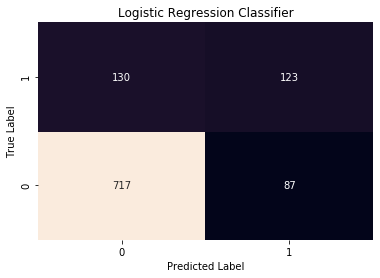

Accuracy Score 0.7947019867549668
AUC 0.8334046172300553
Precision score 0.5857142857142857
Recall score 0.48616600790513836


In [37]:
# logit
lr_model = linear_model.LogisticRegression(random_state = 123)
lr_model.fit(x_train, y_train)
lr_pred = lr_model.predict(x_test)
lr_proba = lr_model.predict_proba(x_test)
lr_proba = lr_proba[:,1]
lr_auc = roc_auc_score(y_test, lr_proba)
lr_score = lr_model.score(x_test,y_test)
lr_recall = recall_score(y_test, lr_pred)
lr_precision  = precision_score(y_test, lr_pred)
lr_result_mat = confusion_matrix(y_test,lr_pred)

sns.heatmap(lr_result_mat,
            # square = True,
            annot = True,
            fmt = 'd',
            cbar = False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Classifier')
plt.ylim(0,2)
plt.show()

print('Accuracy Score {}'.format(lr_score))
print('AUC {}'.format(lr_auc))
print('Precision score {}'.format(lr_precision))
print('Recall score {}'.format(lr_recall))

In [40]:
# score the testing data and export as .csv

Xt,y = do_data(testing)
Xt = encoder.transform(Xt)

Xt = bestcoefs.transform(Xt)
scores = lr_model.predict_proba(Xt)[:,1]

final_scores = pd.DataFrame()
final_scores['Customer Number'] = testing.iloc[:,0]
final_scores['Churn'] = scores

#Exporting .csv 
now = datetime.now().strftime('%m/%d/%Y-%H/%M')

filename = ('Waggoner_scores_' + str(now))
#filename = filename.replace(" ", "_")
filename = filename.replace("/", "-")


print('exporting file ' + filename + '.csv...' )

final_scores.to_csv(filename + '.csv', header = True)

exporting file Waggoner_scores_02-17-2020-09-08.csv...


In [25]:
#test performance of different encoding methods
encoders = (
ce.BackwardDifferenceEncoder(),
ce.BaseNEncoder(),
ce.BinaryEncoder(),
ce.CatBoostEncoder(),
#ce.HashingEncoder(),
ce.HelmertEncoder(),
ce.JamesSteinEncoder(),
#ce.LeaveOneOutEncoder(),
ce.MEstimateEncoder(),
ce.OneHotEncoder(),
ce.OrdinalEncoder(),
ce.SumEncoder(),
ce.PolynomialEncoder(),
ce.TargetEncoder(),
ce.WOEEncoder()
)

for encoder in encoders:
    X, y = do_data(training, has_y = True)
    encoder.fit(X,y)
    X = encoder.transform(X)
    x_train, x_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20,
                                                    random_state = 5)
    lr_model = linear_model.LogisticRegression(random_state = 123)
    scores = cross_val_score(lr_model,
                             x_train,
                             y_train,
                             cv = 10,
                            scoring = 'roc_auc')
    print(str(encoder)[:20] + " " + str(np.mean(scores)))


BackwardDifferenceEn 0.8527377345758964
BaseNEncoder(base=2, 0.8530388174633469
BinaryEncoder(cols=N 0.8530388174633469
CatBoostEncoder(a=1, 0.8341424398647078
HelmertEncoder(cols= 0.8535905501598888
JamesSteinEncoder(co 0.8327263597710266
MEstimateEncoder(col 0.8341424398647078
OneHotEncoder(cols=[ 0.8540710523927405
OrdinalEncoder(cols= 0.8507399340061912
SumEncoder(cols=['ge 0.8534581646115493
PolynomialEncoder(co 0.8532202293471762
TargetEncoder(cols=[ 0.8318979524421527
WOEEncoder(cols=['ge 0.8510830912648801
